In [11]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### **Data Loading**

In [6]:
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 6s 0us/step
train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


### **Preprocessing**
train_test_split은 이미 분리되어 있으므로 수행하지 않음

In [7]:
def preprocessed_data(images, labels):
    # 이미지 scale 및 float32 형 변형
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

def ohe_data(images, labels):
    # 라벨 원핫인코딩 적용
    images, labels = preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

In [8]:
train_images, train_labels = ohe_data(train_images, train_labels)
test_images, test_labels = ohe_data(test_images, test_labels)
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 10)


### **Modeling**

In [9]:
IMAGE_SIZE = 32

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # 배치제외 3차원

x = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten(name='Flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(train_labels.shape[1], activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

#### **가중치 초기화와 배치 정규화**
* **WI** (glorot_uniform(default)) , **BN** (x) --> 0.7968
* **WI** (he_normal), **BN** (O) --> 0.8271   
배치정규화를 하면 가중치 초기화는 영향이 낮아짐

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_images, y=train_labels, batch_size=32, epochs=30, validation_split=0.15)

#### **배치 사이즈**
* batch_size (64) -> 0.8271
* batch_size (32) -> 0.8387

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_labels)

### **Modeling_2**
* Callback - Learning Rate(LR) 조정, EarlyStopping 적용
* 필터의 개수를 2배씩 증가
* Global Average Pooling(GAP) 적용

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # 배치제외 3차원

x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x) # MaxPooling or Stride 2

# GlobalAveragePooling
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='GAP1')(x)
x = Dropout(rate=0.2)(x)
output = Dense(train_labels.shape[1], activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 64)        0   

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=train_images, y=train_labels, batch_size=32, epochs=30, validation_split=0.15,
                   callbacks=[rlr_cb, ely_cb])

2022-03-27 13:42:36.334701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-03-27 13:42:38.381965: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1329/1329 [==============================] - 21s 10ms/step - loss: 1.5523 - accuracy: 0.4273 - val_loss: 1.2478 - val_accuracy: 0.5535
Epoch 2/30
1329/1329 [==============================] - 13s 9ms/step - loss: 1.1182 - accuracy: 0.5991 - val_loss: 1.1369 - val_accuracy: 0.5944
Epoch 3/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.9361 - accuracy: 0.6685 - val_loss: 0.8480 - val_accuracy: 0.7037
Epoch 4/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.7984 - accuracy: 0.7226 - val_loss: 0.8102 - val_accuracy: 0.7105
Epoch 5/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.6905 - accuracy: 0.7625 - val_loss: 0.9578 - val_accuracy: 0.6831
Epoch 6/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.6034 - accuracy: 0.7976 - val_loss: 0.7925 - val_accuracy: 0.7412
Epoch 7/30
1329/1329 [==============================] - 13s 10ms/step - loss: 0.5329 - accuracy: 0.8220 - val_loss: 0.7799 - val_accuracy: 

313/313 [==============================] - 1s 5ms/step - loss: 0.7268 - accuracy: 0.8682


[0.7267776131629944, 0.8682000041007996]

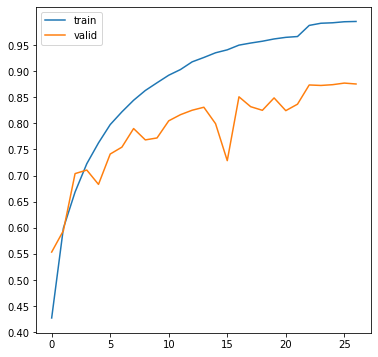

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_labels)

* LR 동적 변경이 성능에 영향을 미침 -> 0.8682
* GAP는 채널수에 따라 flatten과 비교하여 사용
* val_accuracy가 불안정하므로 layer를 추가하고 epochs을 늘려보는 시도 가능